In [1]:
# import libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.metrics.pairwise import pairwise_distances
from sklearn.metrics import mean_squared_error

import math
from math import sqrt

from surprise.model_selection import train_test_split
from surprise import accuracy
from surprise import Reader, Dataset, SVD
from surprise.model_selection import cross_validate

## Data Pre-processing

In [2]:
# Reading the Ratings files
df_ratings = pd.read_csv('/Users/amy/Documents/DISSERTATION/Data/ml-latest-small/ratings.csv', usecols = ['userId','movieId', 'rating'])
df_ratings

,userId,movieId,rating
0,1,1,4.0
1,1,3,4.0
2,1,6,4.0
3,1,47,5.0
4,1,50,5.0
...,...,...,...
100831,610,166534,4.0
100832,610,168248,5.0
100833,610,168250,5.0
100834,610,168252,5.0


In [3]:
# Reading the Movie files
df_movies = pd.read_csv('/Users/amy/Documents/DISSERTATION/Data/ml-latest-small/movies.csv', usecols = ['movieId','genres'])
df_movies

,movieId,genres
0,1,Adventure|Animation|Children|Comedy|Fantasy
1,2,Adventure|Children|Fantasy
2,3,Comedy|Romance
3,4,Comedy|Drama|Romance
4,5,Comedy
...,...,...
9737,193581,Action|Animation|Comedy|Fantasy
9738,193583,Animation|Comedy|Fantasy
9739,193585,Drama
9740,193587,Action|Animation


In [4]:
# cleaning genres feature (to list)
df_movies['genres'] = df_movies['genres'].str.split('|')
df_movies.genres

0       [Adventure, Animation, Children, Comedy, Fantasy]
1                          [Adventure, Children, Fantasy]
2                                       [Comedy, Romance]
3                                [Comedy, Drama, Romance]
4                                                [Comedy]
                              ...                        
9737                 [Action, Animation, Comedy, Fantasy]
9738                         [Animation, Comedy, Fantasy]
9739                                              [Drama]
9740                                  [Action, Animation]
9741                                             [Comedy]
Name: genres, Length: 9742, dtype: object

In [5]:
# Reading the Links files
df_links = pd.read_csv('/Users/amy/Documents/DISSERTATION/Data/ml-latest-small/links.csv', usecols = ['movieId','tmdbId'])
df_links

,movieId,tmdbId
0,1,862.0
1,2,8844.0
2,3,15602.0
3,4,31357.0
4,5,11862.0
...,...,...
9737,193581,432131.0
9738,193583,445030.0
9739,193585,479308.0
9740,193587,483455.0


In [6]:
df1 = pd.merge(df_ratings, df_movies)
df_basic = pd.merge(df_links, df1)
df_basic

,movieId,tmdbId,userId,rating,genres
0,1,862.0,1,4.0,"[Adventure, Animation, Children, Comedy, Fantasy]"
1,1,862.0,5,4.0,"[Adventure, Animation, Children, Comedy, Fantasy]"
2,1,862.0,7,4.5,"[Adventure, Animation, Children, Comedy, Fantasy]"
3,1,862.0,15,2.5,"[Adventure, Animation, Children, Comedy, Fantasy]"
4,1,862.0,17,4.5,"[Adventure, Animation, Children, Comedy, Fantasy]"
...,...,...,...,...,...
100831,193581,432131.0,184,4.0,"[Action, Animation, Comedy, Fantasy]"
100832,193583,445030.0,184,3.5,"[Animation, Comedy, Fantasy]"
100833,193585,479308.0,184,3.5,[Drama]
100834,193587,483455.0,184,3.5,"[Action, Animation]"


In [7]:
# Reading the Content files
df_contents = pd.read_csv('/Users/amy/Documents/DISSERTATION/Data/movies 2.csv', usecols= ['title','id','overview','popularity','vote_average','vote_count','credits','keywords','tagline'])
df_contents.rename(columns={'id':'tmdbId'}, inplace=True)
df_contents

,tmdbId,title,overview,popularity,tagline,vote_average,vote_count,credits,keywords
0,76600,Avatar: The Way of Water,Set more than a decade after the events of the...,9366.788,Return to Pandora.,7.751,6748.0,Sam Worthington-Zoe Saldaña-Sigourney Weaver-S...,loss of loved one-dying and death-alien life-f...
1,758323,The Pope's Exorcist,Father Gabriele Amorth Chief Exorcist of the V...,5953.227,Inspired by the actual files of Father Gabriel...,7.433,545.0,Russell Crowe-Daniel Zovatto-Alex Essoe-Franco...,spain-rome italy-vatican-pope-pig-possession-c...
2,385687,Fast X,Over many missions and against impossible odds...,4830.683,The end of the road begins.,7.021,550.0,Vin Diesel-Michelle Rodriguez-Tyrese Gibson-Lu...,sequel-revenge-racing-family-duringcreditsstin...
3,640146,Ant-Man and the Wasp: Quantumania,Super-Hero partners Scott Lang and Hope van Dy...,4425.387,Witness the beginning of a new dynasty.,6.507,2811.0,Paul Rudd-Evangeline Lilly-Jonathan Majors-Kat...,hero-ant-sequel-superhero-based on comic-famil...
4,677179,Creed III,After dominating the boxing world Adonis Creed...,3994.342,You can't run from your past.,7.262,1129.0,Michael B. Jordan-Tessa Thompson-Jonathan Majo...,philadelphia pennsylvania-husband wife relatio...
...,...,...,...,...,...,...,...,...,...
722823,854110,Existential,A reflection of a journey that took us back to...,0.600,A reflection of a journey that took us back to...,10.000,1.0,Joyce Sagayca Fernandez-Mohammad Haris Sharif-...,planet mars
722824,849243,Kentucky Minstrels,'Old-time minstrel sinks to poverty and rises ...,0.600,NaN,0.000,0.0,Harry Scott-Eddie Whaley Sr.-Nina Mae McKinney...,NaN
722825,884042,Arroio Part III,NaN,0.600,NaN,0.000,0.0,NaN,NaN
722826,759943,"Live, Dance, Pose",An underground scene that has survived for dec...,0.600,NaN,0.000,0.0,NaN,NaN


In [8]:
df_enhance = pd.merge(df_basic, df_contents, on = 'tmdbId')
df_enhance = df_enhance.drop_duplicates(['userId', 'movieId'])
df_enhance

,movieId,tmdbId,userId,rating,genres,title,overview,popularity,tagline,vote_average,vote_count,credits,keywords
0,1,862.0,1,4.0,"[Adventure, Animation, Children, Comedy, Fantasy]",Toy Story,Led by Woody Andy's toys live happily in his r...,111.892,NaN,7.966,16430.0,Tom Hanks-Tim Allen-Don Rickles-Jim Varney-Wal...,martial arts-jealousy-friendship-bullying-elem...
1,1,862.0,5,4.0,"[Adventure, Animation, Children, Comedy, Fantasy]",Toy Story,Led by Woody Andy's toys live happily in his r...,111.892,NaN,7.966,16430.0,Tom Hanks-Tim Allen-Don Rickles-Jim Varney-Wal...,martial arts-jealousy-friendship-bullying-elem...
2,1,862.0,7,4.5,"[Adventure, Animation, Children, Comedy, Fantasy]",Toy Story,Led by Woody Andy's toys live happily in his r...,111.892,NaN,7.966,16430.0,Tom Hanks-Tim Allen-Don Rickles-Jim Varney-Wal...,martial arts-jealousy-friendship-bullying-elem...
3,1,862.0,15,2.5,"[Adventure, Animation, Children, Comedy, Fantasy]",Toy Story,Led by Woody Andy's toys live happily in his r...,111.892,NaN,7.966,16430.0,Tom Hanks-Tim Allen-Don Rickles-Jim Varney-Wal...,martial arts-jealousy-friendship-bullying-elem...
4,1,862.0,17,4.5,"[Adventure, Animation, Children, Comedy, Fantasy]",Toy Story,Led by Woody Andy's toys live happily in his r...,111.892,NaN,7.966,16430.0,Tom Hanks-Tim Allen-Don Rickles-Jim Varney-Wal...,martial arts-jealousy-friendship-bullying-elem...
...,...,...,...,...,...,...,...,...,...,...,...,...,...
100345,193581,432131.0,184,4.0,"[Action, Animation, Comedy, Fantasy]",Black Butler: Book of the Atlantic,"Ciel learns of a ""Aurora Society"" that is rumo...",10.050,NaN,7.653,72.0,Daisuke Ono-Maaya Sakamoto-Yukari Tamura-Junic...,butler-victorian england-based on manga-dark f...
100346,193583,445030.0,184,3.5,"[Animation, Comedy, Fantasy]",No Game No Life: Zero,In ancient Disboard Riku is an angry young war...,28.732,NaN,7.900,301.0,Yoko Hikasa-Ai Kayano-Yoshitsugu Matsuoka-Kazu...,based on novel or book-anti hero-magic-post-ap...
100347,193585,479308.0,184,3.5,[Drama],Flint,A woman deals with the toxic water scandal in ...,3.661,NaN,6.800,16.0,Queen Latifah-Betsy Brandt-Rob Morrow-Marin Ir...,NaN
100348,193587,483455.0,184,3.5,"[Action, Animation]",Bungo Stray Dogs: Dead Apple,A large scale catastrophe is occurring across ...,28.680,NaN,8.300,114.0,Kensho Ono-Mamoru Miyano-Kisho Taniyama-Yuto U...,supernatural-mafia-based on manga-super power-...


In [9]:
# Step 1: Calculate the number of ratings for each movie
movie_ratings_count = df_enhance['movieId'].value_counts()

# Step 2: Filter the movies that have more than 20 ratings
popular_movies = movie_ratings_count[movie_ratings_count > 20].index

# Step 3: Create a new DataFrame with the filtered movies
df_enhance = df_enhance[df_enhance['movieId'].isin(popular_movies)]
df_enhance

,movieId,tmdbId,userId,rating,genres,title,overview,popularity,tagline,vote_average,vote_count,credits,keywords
0,1,862.0,1,4.0,"[Adventure, Animation, Children, Comedy, Fantasy]",Toy Story,Led by Woody Andy's toys live happily in his r...,111.892,NaN,7.966,16430.0,Tom Hanks-Tim Allen-Don Rickles-Jim Varney-Wal...,martial arts-jealousy-friendship-bullying-elem...
1,1,862.0,5,4.0,"[Adventure, Animation, Children, Comedy, Fantasy]",Toy Story,Led by Woody Andy's toys live happily in his r...,111.892,NaN,7.966,16430.0,Tom Hanks-Tim Allen-Don Rickles-Jim Varney-Wal...,martial arts-jealousy-friendship-bullying-elem...
2,1,862.0,7,4.5,"[Adventure, Animation, Children, Comedy, Fantasy]",Toy Story,Led by Woody Andy's toys live happily in his r...,111.892,NaN,7.966,16430.0,Tom Hanks-Tim Allen-Don Rickles-Jim Varney-Wal...,martial arts-jealousy-friendship-bullying-elem...
3,1,862.0,15,2.5,"[Adventure, Animation, Children, Comedy, Fantasy]",Toy Story,Led by Woody Andy's toys live happily in his r...,111.892,NaN,7.966,16430.0,Tom Hanks-Tim Allen-Don Rickles-Jim Varney-Wal...,martial arts-jealousy-friendship-bullying-elem...
4,1,862.0,17,4.5,"[Adventure, Animation, Children, Comedy, Fantasy]",Toy Story,Led by Woody Andy's toys live happily in his r...,111.892,NaN,7.966,16430.0,Tom Hanks-Tim Allen-Don Rickles-Jim Varney-Wal...,martial arts-jealousy-friendship-bullying-elem...
...,...,...,...,...,...,...,...,...,...,...,...,...,...
99858,168252,263115.0,567,4.0,"[Action, Sci-Fi]",Logan,In the near future a weary Logan cares for an ...,68.993,His time has come.,7.815,17552.0,Hugh Jackman-Dafne Keen-Patrick Stewart-Elizab...,cyborg-experiment-self-destruction-mutant-futu...
99859,168252,263115.0,586,5.0,"[Action, Sci-Fi]",Logan,In the near future a weary Logan cares for an ...,68.993,His time has come.,7.815,17552.0,Hugh Jackman-Dafne Keen-Patrick Stewart-Elizab...,cyborg-experiment-self-destruction-mutant-futu...
99860,168252,263115.0,596,5.0,"[Action, Sci-Fi]",Logan,In the near future a weary Logan cares for an ...,68.993,His time has come.,7.815,17552.0,Hugh Jackman-Dafne Keen-Patrick Stewart-Elizab...,cyborg-experiment-self-destruction-mutant-futu...
99861,168252,263115.0,599,3.5,"[Action, Sci-Fi]",Logan,In the near future a weary Logan cares for an ...,68.993,His time has come.,7.815,17552.0,Hugh Jackman-Dafne Keen-Patrick Stewart-Elizab...,cyborg-experiment-self-destruction-mutant-futu...


In [10]:
df_enhance['credits'] = df_enhance['credits'].astype(str)
df_enhance['keywords'] = df_enhance['keywords'].astype(str)
df_enhance['genres'] = df_enhance['genres'].astype(str)

/var/folders/j7/nfnl2t8n67z4s5c_jkpvv_w80000gn/T/ipykernel_51513/2889399598.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_enhance['credits'] = df_enhance['credits'].astype(str)
/var/folders/j7/nfnl2t8n67z4s5c_jkpvv_w80000gn/T/ipykernel_51513/2889399598.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_enhance['keywords'] = df_enhance['keywords'].astype(str)
/var/folders/j7/nfnl2t8n67z4s5c_jkpvv_w80000gn/T/ipykernel_51513/2889399598.py:3: SettingWithCopyWarning: 
A value is trying to be set on 

In [11]:
# cleaning credits feature (to list)
df_enhance['credits'] = df_enhance['credits'].str.split('-')
df_enhance['credits'] = df_enhance['credits'].apply(lambda lst: ', '.join(str(elem).replace(' ', '_') for elem in lst[:5] if isinstance(elem, str)))
df_enhance.credits

/var/folders/j7/nfnl2t8n67z4s5c_jkpvv_w80000gn/T/ipykernel_51513/3511891904.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_enhance['credits'] = df_enhance['credits'].str.split('-')
/var/folders/j7/nfnl2t8n67z4s5c_jkpvv_w80000gn/T/ipykernel_51513/3511891904.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_enhance['credits'] = df_enhance['credits'].apply(lambda lst: ', '.join(str(elem).replace(' ', '_') for elem in lst[:5] if isinstance(elem, str)))


0        Tom_Hanks, Tim_Allen, Don_Rickles, Jim_Varney,...
1        Tom_Hanks, Tim_Allen, Don_Rickles, Jim_Varney,...
2        Tom_Hanks, Tim_Allen, Don_Rickles, Jim_Varney,...
3        Tom_Hanks, Tim_Allen, Don_Rickles, Jim_Varney,...
4        Tom_Hanks, Tim_Allen, Don_Rickles, Jim_Varney,...
                               ...                        
99858    Hugh_Jackman, Dafne_Keen, Patrick_Stewart, Eli...
99859    Hugh_Jackman, Dafne_Keen, Patrick_Stewart, Eli...
99860    Hugh_Jackman, Dafne_Keen, Patrick_Stewart, Eli...
99861    Hugh_Jackman, Dafne_Keen, Patrick_Stewart, Eli...
99862    Hugh_Jackman, Dafne_Keen, Patrick_Stewart, Eli...
Name: credits, Length: 66479, dtype: object

In [12]:
# cleaning keywords feature (to list)
df_enhance['keywords'] = df_enhance['keywords'].str.split('-')
df_enhance['keywords'] = df_enhance['keywords'].apply(lambda lst: ', '.join(str(elem).replace(' ', '_') for elem in lst if isinstance(elem, str)))
df_enhance.keywords

/var/folders/j7/nfnl2t8n67z4s5c_jkpvv_w80000gn/T/ipykernel_51513/3334051811.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_enhance['keywords'] = df_enhance['keywords'].str.split('-')
/var/folders/j7/nfnl2t8n67z4s5c_jkpvv_w80000gn/T/ipykernel_51513/3334051811.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_enhance['keywords'] = df_enhance['keywords'].apply(lambda lst: ', '.join(str(elem).replace(' ', '_') for elem in lst if isinstance(elem, str)))


0        martial_arts, jealousy, friendship, bullying, ...
1        martial_arts, jealousy, friendship, bullying, ...
2        martial_arts, jealousy, friendship, bullying, ...
3        martial_arts, jealousy, friendship, bullying, ...
4        martial_arts, jealousy, friendship, bullying, ...
                               ...                        
99858    cyborg, experiment, self, destruction, mutant,...
99859    cyborg, experiment, self, destruction, mutant,...
99860    cyborg, experiment, self, destruction, mutant,...
99861    cyborg, experiment, self, destruction, mutant,...
99862    cyborg, experiment, self, destruction, mutant,...
Name: keywords, Length: 66479, dtype: object

In [13]:
# Now cumulate all the words on a column, say bag of words :)
df_enhance['bag_of_words'] = df_enhance['credits'] + df_enhance['genres'] + df_enhance['keywords']

def convert_to_string(item):
    if isinstance(item, str):
        return item
    elif isinstance(item, list):
        return ' '.join([str(i) for i in item if not isinstance(i, float)])
    return str(item)  # Convert other types to string

df_enhance['bag_of_words'] = df_enhance['bag_of_words'].apply(convert_to_string)
df_enhance['bag_of_words'] = df_enhance['bag_of_words'].fillna('')
df_enhance['bag_of_words']

/var/folders/j7/nfnl2t8n67z4s5c_jkpvv_w80000gn/T/ipykernel_51513/44331444.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_enhance['bag_of_words'] = df_enhance['credits'] + df_enhance['genres'] + df_enhance['keywords']
/var/folders/j7/nfnl2t8n67z4s5c_jkpvv_w80000gn/T/ipykernel_51513/44331444.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_enhance['bag_of_words'] = df_enhance['bag_of_words'].apply(convert_to_string)
/var/folders/j7/nfnl2t8n67z4s5c_jkpvv_w80000gn/T/ipykernel_51513/44331444.py:12

0        Tom_Hanks, Tim_Allen, Don_Rickles, Jim_Varney,...
1        Tom_Hanks, Tim_Allen, Don_Rickles, Jim_Varney,...
2        Tom_Hanks, Tim_Allen, Don_Rickles, Jim_Varney,...
3        Tom_Hanks, Tim_Allen, Don_Rickles, Jim_Varney,...
4        Tom_Hanks, Tim_Allen, Don_Rickles, Jim_Varney,...
                               ...                        
99858    Hugh_Jackman, Dafne_Keen, Patrick_Stewart, Eli...
99859    Hugh_Jackman, Dafne_Keen, Patrick_Stewart, Eli...
99860    Hugh_Jackman, Dafne_Keen, Patrick_Stewart, Eli...
99861    Hugh_Jackman, Dafne_Keen, Patrick_Stewart, Eli...
99862    Hugh_Jackman, Dafne_Keen, Patrick_Stewart, Eli...
Name: bag_of_words, Length: 66479, dtype: object

In [14]:
# Now cumulate all the words on a column, say bag of words :)
df_enhance['bag_of_words2'] = df_enhance['credits'] + df_enhance['genres'] 
df_enhance['bag_of_words3'] = df_enhance['credits'] + df_enhance['keywords']
df_enhance['bag_of_words4'] = df_enhance['genres'] + df_enhance['keywords']

df_enhance['bag_of_words2'] = df_enhance['bag_of_words2'].apply(convert_to_string)
df_enhance['bag_of_words2'] = df_enhance['bag_of_words2'].fillna('')

df_enhance['bag_of_words3'] = df_enhance['bag_of_words3'].apply(convert_to_string)
df_enhance['bag_of_words3'] = df_enhance['bag_of_words3'].fillna('')

df_enhance['bag_of_words4'] = df_enhance['bag_of_words4'].apply(convert_to_string)
df_enhance['bag_of_words4'] = df_enhance['bag_of_words4'].fillna('')

/var/folders/j7/nfnl2t8n67z4s5c_jkpvv_w80000gn/T/ipykernel_51513/1907348373.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_enhance['bag_of_words2'] = df_enhance['credits'] + df_enhance['genres']
/var/folders/j7/nfnl2t8n67z4s5c_jkpvv_w80000gn/T/ipykernel_51513/1907348373.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_enhance['bag_of_words3'] = df_enhance['credits'] + df_enhance['keywords']
/var/folders/j7/nfnl2t8n67z4s5c_jkpvv_w80000gn/T/ipykernel_51513/1907348373.py:4: SettingWithCopyWarning

In [15]:
n_users = len(np.unique(df_enhance['userId']))
n_items = len(np.unique(df_enhance['movieId']))

n_users,n_items

(610, 1231)

There are 601 users and 703 movies in the whole dataset.

In [16]:
# Calculate sparsity of data
total_ratings = n_users * n_items
# Calculate the sparsity
sparsity = 1 - (df_enhance.shape[0] / total_ratings) # '.shape[0]' return number of rows (index 0 column)

# Print the sparsity
print("Sparsity: {:.2%}".format(sparsity))

Sparsity: 91.15%


## Model Based CF

### SVD

In [17]:
from surprise import Reader, Dataset, SVD
from surprise.model_selection import cross_validate
# Reader is a class in the Surprise library, which is used for reading datasets in a specific format 
reader = Reader(rating_scale=(0.5, 5.0))
#max rating =5 and min rating=0.5
data = Dataset.load_from_df(df_enhance[['userId', 'movieId', 'rating']], reader)

In [23]:
from surprise.model_selection import train_test_split
from surprise import accuracy

# Set a random seed for reproducibility
random_seed = 65

trainset, testset = train_test_split(data, test_size=.25, random_state=random_seed)
model=SVD(n_epochs = 15, n_factors = 10, random_state=random_seed)
model.fit(trainset)
predictions = model.test(testset)
rmse_ori=accuracy.rmse(predictions)
mae_ori=accuracy.mae(predictions)

RMSE: 0.8453
MAE:  0.6474


In [22]:
trainset2 = data.build_full_trainset()
model=SVD(n_epochs = 15, n_factors = 10, random_state=random_seed)
model.fit(trainset2)
predictions = model.test(testset)
rmse_ori3=accuracy.rmse(predictions)

RMSE: 0.8069


In [24]:
# Perform cross validation
results = cross_validate(model, data, measures=['RMSE'], cv=5, verbose=True)

Evaluating RMSE of algorithm SVD on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.8496  0.8368  0.8470  0.8453  0.8419  0.8441  0.0044  
Fit time          0.25    0.24    0.23    0.22    0.21    0.23    0.01    
Test time         0.14    0.07    0.06    0.06    0.06    0.08    0.03    


### NMF

In [25]:
from surprise import NMF
nmf = NMF()
nmf.fit(trainset)
predictions = nmf.test(testset)
rmse_nmf= accuracy.rmse(predictions)

RMSE: 0.8655


### SVD ++

In [26]:
from surprise import SVDpp

# Create the SVD++ model
svdpp = SVDpp()

# Fit the SVD++ model on the training data
svdpp.fit(trainset)

# Get predictions on the test set
predictions_svdpp = svdpp.test(testset)

# Calculate RMSE for SVD++
rmse_svdpp = accuracy.rmse(predictions_svdpp)


RMSE: 0.8341


## Content Based Filtering

In [27]:
import nltk

In [28]:
df_content = df_enhance.drop_duplicates(['title'])
df_content

,movieId,tmdbId,userId,rating,genres,title,overview,popularity,tagline,vote_average,vote_count,credits,keywords,bag_of_words,bag_of_words2,bag_of_words3,bag_of_words4
0,1,862.0,1,4.0,"['Adventure', 'Animation', 'Children', 'Comedy...",Toy Story,Led by Woody Andy's toys live happily in his r...,111.892,NaN,7.966,16430.0,"Tom_Hanks, Tim_Allen, Don_Rickles, Jim_Varney,...","martial_arts, jealousy, friendship, bullying, ...","Tom_Hanks, Tim_Allen, Don_Rickles, Jim_Varney,...","Tom_Hanks, Tim_Allen, Don_Rickles, Jim_Varney,...","Tom_Hanks, Tim_Allen, Don_Rickles, Jim_Varney,...","['Adventure', 'Animation', 'Children', 'Comedy..."
215,2,8844.0,6,4.0,"['Adventure', 'Children', 'Fantasy']",Jumanji,When siblings Judy and Peter discover an encha...,13.680,Roll the dice and unleash the excitement!,7.237,9437.0,"Robin_Williams, Kirsten_Dunst, Bradley_Pierce,...","giant_insect, board_game, jungle, disappearanc...","Robin_Williams, Kirsten_Dunst, Bradley_Pierce,...","Robin_Williams, Kirsten_Dunst, Bradley_Pierce,...","Robin_Williams, Kirsten_Dunst, Bradley_Pierce,...","['Adventure', 'Children', 'Fantasy']giant_inse..."
325,3,15602.0,1,4.0,"['Comedy', 'Romance']",Grumpier Old Men,A family wedding reignites the ancient feud be...,11.879,Still Yelling. Still Fighting. Still Ready for...,6.500,324.0,"Walter_Matthau, Jack_Lemmon, Ann, Margret, Sop...","fishing, halloween, sequel, old_man, best_frie...","Walter_Matthau, Jack_Lemmon, Ann, Margret, Sop...","Walter_Matthau, Jack_Lemmon, Ann, Margret, Sop...","Walter_Matthau, Jack_Lemmon, Ann, Margret, Sop...","['Comedy', 'Romance']fishing, halloween, seque..."
384,5,11862.0,6,5.0,['Comedy'],Father of the Bride Part II,Just when George Banks has recovered from his ...,11.959,Just When His World Is Back To Normal... He's ...,6.200,626.0,"Steve_Martin, Diane_Keaton, Martin_Short, Kimb...","parent_child_relationship, baby, midlife_crisi...","Steve_Martin, Diane_Keaton, Martin_Short, Kimb...","Steve_Martin, Diane_Keaton, Martin_Short, Kimb...","Steve_Martin, Diane_Keaton, Martin_Short, Kimb...","['Comedy']parent_child_relationship, baby, mid..."
433,6,949.0,1,4.0,"['Action', 'Crime', 'Thriller']",Heat,Obsessive master thief Neil McCauley leads a t...,41.334,A Los Angeles crime saga.,7.900,6093.0,"Al_Pacino, Robert_De_Niro, Val_Kilmer, Jon_Voi...","robbery, detective, obsession, chase, thief, h...","Al_Pacino, Robert_De_Niro, Val_Kilmer, Jon_Voi...","Al_Pacino, Robert_De_Niro, Val_Kilmer, Jon_Voi...","Al_Pacino, Robert_De_Niro, Val_Kilmer, Jon_Voi...","['Action', 'Crime', 'Thriller']robbery, detect..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99107,148626,318846.0,18,4.0,['Drama'],The Big Short,The men who made millions from a global econom...,23.086,This is a true story.,7.335,7956.0,"Christian_Bale, Steve_Carell, Ryan_Gosling, Br...","bank, fraud, biography, wall_street, finances,...","Christian_Bale, Steve_Carell, Ryan_Gosling, Br...","Christian_Bale, Steve_Carell, Ryan_Gosling, Br...","Christian_Bale, Steve_Carell, Ryan_Gosling, Br...","['Drama']bank, fraud, biography, wall_street, ..."
99243,152081,269149.0,15,3.0,"['Action', 'Adventure', 'Animation', 'Children...",Zootopia,Determined to prove herself Officer Judy Hopps...,111.664,Welcome to the urban jungle.,7.746,14669.0,"Jason_Bateman, Ginnifer_Goodwin, Idris_Elba, J...","allegory, lion, hippopotamus, fox, elephant, s...","Jason_Bateman, Ginnifer_Goodwin, Idris_Elba, J...","Jason_Bateman, Ginnifer_Goodwin, Idris_Elba, J...","Jason_Bateman, Ginnifer_Goodwin, Idris_Elba, J...","['Action', 'Adventure', 'Animation', 'Children..."
99621,164179,329865.0,18,3.0,['Sci-Fi'],Arrival,Taking place after alien crafts land around th...,54.631,Why are they here?,7.579,15945.0,"Amy_Adams, Jeremy_Renner, Forest_Whitaker, Mic...","spacecraft, time, language, loss, alien, femal...","Amy_Adams, Jeremy_Renner, Forest_Whitaker, Mic...","Amy_Adams, Jeremy_Renner, Forest_Whitaker, Mic...","Amy_Adams, Jeremy_Renner, Forest_Whitaker, Mic...",

In [29]:
from sklearn.feature_extraction.text import TfidfVectorizer

# we are using the Tfidf Vectorizer to analyse the words
tfidf = TfidfVectorizer(analyzer='word',min_df=0,stop_words='english',token_pattern = '[a-zA-Z0-9\-]+')

#Tfdif matrix using the combined column
tfidf_matrix= tfidf.fit_transform(df_content.bag_of_words)

tfidf.get_feature_names_out()

array(['10th', '11', '12th', ..., 'zuniga', 'zurich', 'zutshi'],
      dtype=object)

In [30]:
tfidf_matrix.shape

(1225, 8144)

In [31]:
from sklearn.metrics.pairwise import linear_kernel

#finding the cosine similarity between the contenst
cosine= linear_kernel(tfidf_matrix, tfidf_matrix)

In [32]:
cosine[0]

array([1.        , 0.02764212, 0.02382719, ..., 0.        , 0.02697932,
       0.01106767])

In [33]:
cosine

array([[1.        , 0.02764212, 0.02382719, ..., 0.        , 0.02697932,
        0.01106767],
       [0.02764212, 1.        , 0.        , ..., 0.00519884, 0.01630381,
        0.00576398],
       [0.02382719, 0.        , 1.        , ..., 0.        , 0.01539541,
        0.02122183],
       ...,
       [0.        , 0.00519884, 0.        , ..., 1.        , 0.14113414,
        0.01056802],
       [0.02697932, 0.01630381, 0.01539541, ..., 0.14113414, 1.        ,
        0.02949246],
       [0.01106767, 0.00576398, 0.02122183, ..., 0.01056802, 0.02949246,
        1.        ]])

In [34]:
df_content = df_content.reset_index(drop=True)
ids = pd.Series(df_content.index, index=df_content['title'])
#Dropping the titles which have same names
ids= ids.drop_duplicates()
ids

title
Toy Story                          0
Jumanji                            1
Grumpier Old Men                   2
Father of the Bride Part II        3
Heat                               4
                                ... 
The Big Short                   1220
Zootopia                        1221
Arrival                         1222
Rogue One: A Star Wars Story    1223
Logan                           1224
Length: 1225, dtype: int64

In [35]:
def recommendation(title, cosine=cosine):
    indexes = ids[title]
    # Convert cosine to a list before indexing
    similarity = list(enumerate(cosine[indexes].tolist()))
    similarity = sorted(similarity, key=lambda x: x[1], reverse=True)
    movie_ids = [i[0] for i in similarity]
    result = df_content['title'].iloc[movie_ids]
    result = result[1:100]
    return result

In [36]:
recommendation('Batman')

379      Batman Returns
405      Batman & Robin
1081    The Dark Knight
598          Dick Tracy
999       Batman Begins
             ...       
409        Men in Black
532      A Few Good Men
1212            Ant-Man
196        Multiplicity
555      Police Academy
Name: title, Length: 99, dtype: object

## Hybrid SVD

### Content-based + SVD

In [37]:
def hybrid_pred(user_id, title):
    # Obtaining the similar movies from content_based_recommendation
    similar_movies = recommendation(title)

    # Creating a DataFrame from similar_movies
    movie_id = pd.Series(similar_movies.index.values.tolist())
    similar_movies_title = pd.Series(similar_movies.values)
    df_movies = pd.DataFrame({'movieId': movie_id, 'title': similar_movies_title})

    # Merging the movies from similar_movies with ratings
    similar_movies_id = pd.merge(df_movies, df_ratings, how='inner', on='movieId')

    # Create a new Dataset object for the similar movies
    similar_movies_data = Dataset.load_from_df(similar_movies_id[['userId', 'title', 'rating']], reader)
    
    # Build and train the SVD model using the data for similar movies
    model=SVD(n_epochs = 10, n_factors = 5, random_state=65)
    model.fit(similar_movies_data.build_full_trainset())
   
    # Get the predicted rating from the SVD model
    predicted_rating = model.predict(user_id, title).est
    
    if np.isnan(predicted_rating):
        # Get the average rating for the movie from the original dataset
        average_rating = df_enhance[df_enhance['title'] == title]['rating'].mean()
        
        # Use the average rating as the predicted rating
        predicted_rating = average_rating
    # Finally, we return the predicted rating
    return predicted_rating

print("The predicted rating for hybrid recommendation system is:")
print(hybrid_pred(1, 'Batman'))

The predicted rating for hybrid recommendation system is:
3.804926388708064


In [38]:
# Find the square error
df_title = df_enhance[['userId','title','rating']]
data = Dataset.load_from_df(df_title,reader)

true_ratings = []
predicted_ratings = []

for index, row in df_title.iterrows():
    user_id = row['userId']
    movie_id = row['title']
    true_rating = row['rating']
    
    # Get the combined prediction using the hybrid_pred function
    predicted_rating = hybrid_pred(user_id, movie_id) # Get the numeric value
    
    # Check if the true rating is available (not NaN)
    if not np.isnan(true_rating):
        # Collect the true rating and predicted rating
        true_ratings.append(true_rating)
        predicted_ratings.append(predicted_rating)

rmse_hybrid1 = sqrt(mean_squared_error(true_ratings, predicted_ratings))
print("RMSE:", rmse_hybrid1)

RMSE: 0.9834118762171445


## Extended SVD

### Movie Feature Vectorization

In [39]:
import nltk
from nltk import tokenize
from sklearn.feature_extraction.text import CountVectorizer

In [40]:
df_feature= df_enhance.drop('userId', axis=1)
df_feature=df_feature.drop_duplicates('movieId')
df_feature=df_feature.reset_index(drop=True)
df_feature

,movieId,tmdbId,rating,genres,title,overview,popularity,tagline,vote_average,vote_count,credits,keywords,bag_of_words,bag_of_words2,bag_of_words3,bag_of_words4
0,1,862.0,4.0,"['Adventure', 'Animation', 'Children', 'Comedy...",Toy Story,Led by Woody Andy's toys live happily in his r...,111.892,NaN,7.966,16430.0,"Tom_Hanks, Tim_Allen, Don_Rickles, Jim_Varney,...","martial_arts, jealousy, friendship, bullying, ...","Tom_Hanks, Tim_Allen, Don_Rickles, Jim_Varney,...","Tom_Hanks, Tim_Allen, Don_Rickles, Jim_Varney,...","Tom_Hanks, Tim_Allen, Don_Rickles, Jim_Varney,...","['Adventure', 'Animation', 'Children', 'Comedy..."
1,2,8844.0,4.0,"['Adventure', 'Children', 'Fantasy']",Jumanji,When siblings Judy and Peter discover an encha...,13.680,Roll the dice and unleash the excitement!,7.237,9437.0,"Robin_Williams, Kirsten_Dunst, Bradley_Pierce,...","giant_insect, board_game, jungle, disappearanc...","Robin_Williams, Kirsten_Dunst, Bradley_Pierce,...","Robin_Williams, Kirsten_Dunst, Bradley_Pierce,...","Robin_Williams, Kirsten_Dunst, Bradley_Pierce,...","['Adventure', 'Children', 'Fantasy']giant_inse..."
2,3,15602.0,4.0,"['Comedy', 'Romance']",Grumpier Old Men,A family wedding reignites the ancient feud be...,11.879,Still Yelling. Still Fighting. Still Ready for...,6.500,324.0,"Walter_Matthau, Jack_Lemmon, Ann, Margret, Sop...","fishing, halloween, sequel, old_man, best_frie...","Walter_Matthau, Jack_Lemmon, Ann, Margret, Sop...","Walter_Matthau, Jack_Lemmon, Ann, Margret, Sop...","Walter_Matthau, Jack_Lemmon, Ann, Margret, Sop...","['Comedy', 'Romance']fishing, halloween, seque..."
3,5,11862.0,5.0,['Comedy'],Father of the Bride Part II,Just when George Banks has recovered from his ...,11.959,Just When His World Is Back To Normal... He's ...,6.200,626.0,"Steve_Martin, Diane_Keaton, Martin_Short, Kimb...","parent_child_relationship, baby, midlife_crisi...","Steve_Martin, Diane_Keaton, Martin_Short, Kimb...","Steve_Martin, Diane_Keaton, Martin_Short, Kimb...","Steve_Martin, Diane_Keaton, Martin_Short, Kimb...","['Comedy']parent_child_relationship, baby, mid..."
4,6,949.0,4.0,"['Action', 'Crime', 'Thriller']",Heat,Obsessive master thief Neil McCauley leads a t...,41.334,A Los Angeles crime saga.,7.900,6093.0,"Al_Pacino, Robert_De_Niro, Val_Kilmer, Jon_Voi...","robbery, detective, obsession, chase, thief, h...","Al_Pacino, Robert_De_Niro, Val_Kilmer, Jon_Voi...","Al_Pacino, Robert_De_Niro, Val_Kilmer, Jon_Voi...","Al_Pacino, Robert_De_Niro, Val_Kilmer, Jon_Voi...","['Action', 'Crime', 'Thriller']robbery, detect..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1226,148626,318846.0,4.0,['Drama'],The Big Short,The men who made millions from a global econom...,23.086,This is a true story.,7.335,7956.0,"Christian_Bale, Steve_Carell, Ryan_Gosling, Br...","bank, fraud, biography, wall_street, finances,...","Christian_Bale, Steve_Carell, Ryan_Gosling, Br...","Christian_Bale, Steve_Carell, Ryan_Gosling, Br...","Christian_Bale, Steve_Carell, Ryan_Gosling, Br...","['Drama']bank, fraud, biography, wall_street, ..."
1227,152081,269149.0,3.0,"['Action', 'Adventure', 'Animation', 'Children...",Zootopia,Determined to prove herself Officer Judy Hopps...,111.664,Welcome to the urban jungle.,7.746,14669.0,"Jason_Bateman, Ginnifer_Goodwin, Idris_Elba, J...","allegory, lion, hippopotamus, fox, elephant, s...","Jason_Bateman, Ginnifer_Goodwin, Idris_Elba, J...","Jason_Bateman, Ginnifer_Goodwin, Idris_Elba, J...","Jason_Bateman, Ginnifer_Goodwin, Idris_Elba, J...","['Action', 'Adventure', 'Animation', 'Children..."
1228,164179,329865.0,3.0,['Sci-Fi'],Arrival,Taking place after alien crafts land around th...,54.631,Why are they here?,7.579,15945.0,"Amy_Adams, Jeremy_Renner, Forest_Whitaker, Mic...","spacecraft, time, language, loss, alien, femal...","Amy_Adams, Jeremy_Renner, Forest_Whitaker, Mic...","Amy_Adams, Jeremy_Renner, Forest_Whitaker, Mic...","Amy_Adams, Jeremy_Renner, Forest_Whitaker, Mic...","['Sci-Fi']spacecraft, time, language, lo

In [41]:
cv= CountVectorizer()

In [42]:
sentences = df_feature.bag_of_words
sentences2 = df_feature.bag_of_words2
sentences3 = df_feature.bag_of_words3
sentences4 = df_feature.bag_of_words4

In [43]:
X=cv.fit(sentences)
W=cv.fit(sentences2)
Y=cv.fit(sentences3)
Z=cv.fit(sentences4)

In [44]:
print(X.get_feature_names())

['10th_century', '11', '12th_century', '13th_century', '15th_century', '16th_century', '1750s', '1790s', '17th_century', '1800s', '1860s', '1870s', '18th_century', '1910s', '1917', '1920s', '1930s', '1940s', '1950s', '1960s', '1970s', '1980s', '1990s', '19th_century', '1st_century', '2000s', '2010s', '2020s', '2030s', '2040s', '2050s', '2060s', '2080s', '2090s', '23rd_century', '24th_century', '2nd_century', '3rd_century_bc', '4th_of_july', '5th_century_bc', '80s_throwback', '9th_century', '_air_force', '_congress', '_hyde', '_india', '_johnson', '_juliet', '_kennedy', '_life', '_louis_missouri', '_marine', '_marine_corps', '_marshal', '_navy', '_navy_seal', '_petersburg_russia', '_quarter', '_roll', '_secret_service_agent', '_senator', '_soldier', '_sports_team', '_valentine', '_woman', '_wonders', 'abandoned_house', 'abandoned_mine', 'abandoned_woman', 'abduction', 'abortion', 'abortionist', 'abraham_lincoln', 'absurdism', 'absurdist', 'abuse', 'abuse_of_power', 'abusive_father', 'ab

/Users/amy/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [45]:
print(W.get_feature_names())

['10th_century', '11', '12th_century', '13th_century', '15th_century', '16th_century', '1750s', '1790s', '17th_century', '1800s', '1860s', '1870s', '18th_century', '1910s', '1917', '1920s', '1930s', '1940s', '1950s', '1960s', '1970s', '1980s', '1990s', '19th_century', '1st_century', '2000s', '2010s', '2020s', '2030s', '2040s', '2050s', '2060s', '2080s', '2090s', '23rd_century', '24th_century', '2nd_century', '3rd_century_bc', '4th_of_july', '5th_century_bc', '80s_throwback', '9th_century', '_air_force', '_congress', '_hyde', '_india', '_johnson', '_juliet', '_kennedy', '_life', '_louis_missouri', '_marine', '_marine_corps', '_marshal', '_navy', '_navy_seal', '_petersburg_russia', '_quarter', '_roll', '_secret_service_agent', '_senator', '_soldier', '_sports_team', '_valentine', '_woman', '_wonders', 'abandoned_house', 'abandoned_mine', 'abandoned_woman', 'abduction', 'abortion', 'abortionist', 'abraham_lincoln', 'absurdism', 'absurdist', 'abuse', 'abuse_of_power', 'abusive_father', 'ab

In [46]:
print(Y.get_feature_names())

['10th_century', '11', '12th_century', '13th_century', '15th_century', '16th_century', '1750s', '1790s', '17th_century', '1800s', '1860s', '1870s', '18th_century', '1910s', '1917', '1920s', '1930s', '1940s', '1950s', '1960s', '1970s', '1980s', '1990s', '19th_century', '1st_century', '2000s', '2010s', '2020s', '2030s', '2040s', '2050s', '2060s', '2080s', '2090s', '23rd_century', '24th_century', '2nd_century', '3rd_century_bc', '4th_of_july', '5th_century_bc', '80s_throwback', '9th_century', '_air_force', '_congress', '_hyde', '_india', '_johnson', '_juliet', '_kennedy', '_life', '_louis_missouri', '_marine', '_marine_corps', '_marshal', '_navy', '_navy_seal', '_petersburg_russia', '_quarter', '_roll', '_secret_service_agent', '_senator', '_soldier', '_sports_team', '_valentine', '_woman', '_wonders', 'abandoned_house', 'abandoned_mine', 'abandoned_woman', 'abduction', 'abortion', 'abortionist', 'abraham_lincoln', 'absurdism', 'absurdist', 'abuse', 'abuse_of_power', 'abusive_father', 'ab

In [47]:
print(Z.get_feature_names())

['10th_century', '11', '12th_century', '13th_century', '15th_century', '16th_century', '1750s', '1790s', '17th_century', '1800s', '1860s', '1870s', '18th_century', '1910s', '1917', '1920s', '1930s', '1940s', '1950s', '1960s', '1970s', '1980s', '1990s', '19th_century', '1st_century', '2000s', '2010s', '2020s', '2030s', '2040s', '2050s', '2060s', '2080s', '2090s', '23rd_century', '24th_century', '2nd_century', '3rd_century_bc', '4th_of_july', '5th_century_bc', '80s_throwback', '9th_century', '_air_force', '_congress', '_hyde', '_india', '_johnson', '_juliet', '_kennedy', '_life', '_louis_missouri', '_marine', '_marine_corps', '_marshal', '_navy', '_navy_seal', '_petersburg_russia', '_quarter', '_roll', '_secret_service_agent', '_senator', '_soldier', '_sports_team', '_valentine', '_woman', '_wonders', 'abandoned_house', 'abandoned_mine', 'abandoned_woman', 'abduction', 'abortion', 'abortionist', 'abraham_lincoln', 'absurdism', 'absurdist', 'abuse', 'abuse_of_power', 'abusive_father', 'ab

In [48]:
X = cv.transform(sentences)
W = cv.transform(sentences2)
Y = cv.transform(sentences3)
Z = cv.transform(sentences4)

In [49]:
feature_vector=pd.DataFrame(X.toarray(), columns=cv.get_feature_names())
feature_vector

,10th_century,11,12th_century,13th_century,15th_century,16th_century,1750s,1790s,17th_century,1800s,...,zombie,zombie_apocalypse,zombification,zoo,zookeeper,zoologist,zoophilia,zorro,zurich,勇敢的心
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1226,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1227,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1228,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1229,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [50]:
movie_feature=X.toarray()
movie_feature2=W.toarray()
movie_feature3=Y.toarray()
movie_feature4=Z.toarray()

In [51]:
from sklearn.decomposition import PCA
# Apply PCA to compress the movie feature matrix to 100 columns
pca = PCA(n_components=100)
movie_feature_compressed = pca.fit_transform(movie_feature)


In [52]:
pca2 = PCA(n_components=100)
movie_feature_compressed2 = pca2.fit_transform(movie_feature2)

In [53]:
pca3 = PCA(n_components=100)
movie_feature_compressed3 = pca3.fit_transform(movie_feature3)

In [54]:
pca4 = PCA(n_components=100)
movie_feature_compressed4 = pca4.fit_transform(movie_feature4)

### Incorporate Feature Vector into V_transpose

In [55]:
from surprise import Reader, Dataset, SVD
from surprise.model_selection import cross_validate
# Reader is a class in the Surprise library, which is used for reading datasets in a specific format 
reader = Reader(rating_scale=(0.5, 5.0))
#max rating =5 and min rating=0.5
data = Dataset.load_from_df(df_enhance[['userId', 'movieId', 'rating']], reader)
data

In [56]:
# Create the SVD model
model = SVD(n_epochs = 15, n_factors = 100, random_state=random_seed)

# Train the model
trainset = data.build_full_trainset()
model.fit(trainset)

# Access the V^T matrix (right singular vectors)
V_transpose_original = model.qi
V_transpose_original

array([[-0.16078425,  0.03420812,  0.04648355, ...,  0.16203214,
         0.04356104, -0.10350161],
       [-0.00301904,  0.17543509,  0.10747407, ..., -0.06209753,
        -0.03585288,  0.29407605],
       [-0.15896717,  0.09345417,  0.20048587, ...,  0.17707305,
         0.00148112, -0.20275118],
       ...,
       [-0.07966699, -0.04670125,  0.1699578 , ...,  0.1426663 ,
         0.05451805,  0.12609537],
       [ 0.05258234, -0.02633338, -0.04551283, ..., -0.11620306,
        -0.08760063,  0.22318866],
       [ 0.11636337, -0.14472007, -0.09136832, ...,  0.0552469 ,
         0.19776112,  0.06381197]])

In [57]:
V_hat = V_transpose_original + movie_feature_compressed
V_hat

array([[-5.34861652e-01, -1.28392724e+00,  1.26078977e-01, ...,
        -5.33719372e-04,  3.16338995e-01,  1.53396253e-01],
       [-1.99892159e-02, -5.14872631e-01, -1.09801746e-01, ...,
         2.45232898e-02, -3.58160478e-02,  3.63545860e-01],
       [-9.04834213e-01, -5.75427366e-01,  4.71643632e-01, ...,
        -3.94944370e-02, -5.23583085e-02, -3.07008633e-02],
       ...,
       [ 7.23396878e-01, -3.10739496e-01, -5.77482872e-01, ...,
         5.48979033e-03, -4.51272429e-01,  5.77143035e-01],
       [ 1.54586085e+00, -8.47400159e-01, -6.91691323e-01, ...,
        -7.37397432e-02, -2.85696984e-01,  3.17795853e-01],
       [ 1.67981137e+00, -4.54394223e-01, -3.35877878e-01, ...,
        -1.60210614e-03,  3.17256782e-01,  1.04764823e-01]])

In [58]:
# Create a new SVD model with the updated V^T matrix
updated_model = SVD(n_epochs = 15, n_factors = 100, random_state=random_seed)  # Assuming 100 latent factors (components) for the updated model
updated_model.fit(trainset)
updated_model.qi = V_hat  # Assign the updated V^T matrix to the new model

# Make predictions using the updated model
user_id = 1
movie_id = 2  # Assuming user 5 has not rated Movie4
predicted_rating = updated_model.predict(uid=user_id, iid=movie_id, r_ui=None, clip=True).est
print("Predicted Rating with the updated model:", predicted_rating)

Predicted Rating with the updated model: 4.542039590854929


In [59]:
predictions_fm = updated_model.test(trainset.build_testset())
rmse_ext=accuracy.rmse(predictions_fm)

RMSE: 0.7640


In [60]:
# Perform cross validation
results_extended = cross_validate(updated_model, data, measures=['RMSE'], cv=5, verbose=True)

Evaluating RMSE of algorithm SVD on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.8347  0.8451  0.8439  0.8541  0.8538  0.8463  0.0072  
Fit time          0.46    0.47    0.49    0.50    0.49    0.48    0.02    
Test time         0.07    0.21    0.09    0.08    0.07    0.10    0.05    


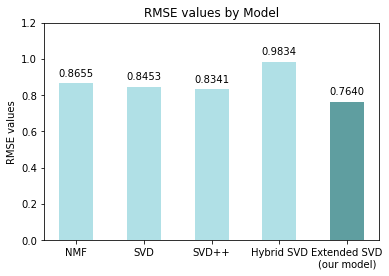

In [77]:
import matplotlib.pyplot as plt
import numpy as np

labels = ['NMF', 'SVD', 'SVD++', 'Hybrid SVD', 'Extended SVD\n(our model)']
x = np.arange(len(labels))  # the label locations
width = 0.5  # the width of the bars

fig, ax = plt.subplots()

rmse_values = [rmse_nmf, rmse_ori, rmse_svdpp, rmse_hybrid1, rmse_ext]

# Example RMSE values for each model
colors = ['powderblue', 'powderblue', 'powderblue', 'powderblue', 'cadetblue']  # Three shades of the base color

rects = ax.bar(x, rmse_values, width, color=colors)

# Add some text for labels, title, and custom x-axis tick labels, etc.
ax.set_ylabel('RMSE values')
ax.set_title('RMSE values by Model')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.set_ylim([0, 1.2])  # Set the maximum value of the y-axis to 1.2

# Format the RMSE labels to display only 4 decimal places
for rect, rmse_value in zip(rects, rmse_values):
    height = rect.get_height()
    ax.annotate(f'{rmse_value:.4f}', xy=(rect.get_x() + rect.get_width() / 2, height), xytext=(0, 5),
                textcoords="offset points", ha='center', va='bottom')

# Save the plot as a PNG file
plt.savefig('rmse_baseline.png')

plt.show()


In [76]:
from tabulate import tabulate
# Create a table to display the RMSE values
table_data = []
for label, rmse_value in zip(labels, rmse_values):
    table_data.append([label, f'{rmse_value:.4f}'])

table = tabulate(table_data, headers=['Model', 'RMSE'], tablefmt='grid')

print("\nRMSE values by Model:\n")
print(table)


RMSE values by Model:

+--------------+--------+
| Model        |   RMSE |
+==============+========+
| NMF          | 0.8655 |
+--------------+--------+
| SVD          | 0.8453 |
+--------------+--------+
| SVD++        | 0.8341 |
+--------------+--------+
| Hybrid SVD   | 0.9834 |
+--------------+--------+
| Extended SVD | 0.764  |
| (our model)  |        |
+--------------+--------+


### Incorporate Different Combination of Side Information

In [62]:
V_hat2 = V_transpose_original + movie_feature_compressed2
V_hat3 = V_transpose_original + movie_feature_compressed3
V_hat4 = V_transpose_original + movie_feature_compressed4

In [63]:
# Create a new SVD model with the updated V^T matrix
updated_model2 = SVD(n_epochs = 15, n_factors = 100, random_state=random_seed)  # Assuming 100 latent factors (components) for the updated model
updated_model2.fit(trainset)
updated_model2.qi = V_hat2  # Assign the updated V^T matrix to the new model

# Make predictions using the updated model
user_id = 1
movie_id = 2  # Assuming user 5 has not rated Movie4
predicted_rating2 = updated_model2.predict(uid=user_id, iid=movie_id, r_ui=None, clip=True).est
print("Predicted Rating with the updated model:", predicted_rating2)

Predicted Rating with the updated model: 4.2987016888483085


In [64]:
predictions_fm2 = updated_model2.test(trainset.build_testset())
rmse_ext2=accuracy.rmse(predictions_fm2)

RMSE: 0.7224


In [65]:
# Create a new SVD model with the updated V^T matrix
updated_model3 = SVD(n_epochs = 15, n_factors = 100, random_state=random_seed)  # Assuming 100 latent factors (components) for the updated model
updated_model3.fit(trainset)
updated_model3.qi = V_hat3  # Assign the updated V^T matrix to the new model

# Make predictions using the updated model
user_id = 1
movie_id = 2  # Assuming user 5 has not rated Movie4
predicted_rating3 = updated_model3.predict(uid=user_id, iid=movie_id, r_ui=None, clip=True).est
print("Predicted Rating with the updated model:", predicted_rating3)

Predicted Rating with the updated model: 4.2923016130763685


In [66]:
predictions_fm3 = updated_model3.test(trainset.build_testset())
rmse_ext3=accuracy.rmse(predictions_fm3)

RMSE: 0.7497


In [67]:
# Create a new SVD model with the updated V^T matrix
updated_model4 = SVD(n_epochs = 15, n_factors = 100, random_state=random_seed)  # Assuming 100 latent factors (components) for the updated model
updated_model4.fit(trainset)
updated_model4.qi = V_hat4  # Assign the updated V^T matrix to the new model

# Make predictions using the updated model
user_id = 1
movie_id = 2  # Assuming user 5 has not rated Movie4
predicted_rating4 = updated_model4.predict(uid=user_id, iid=movie_id, r_ui=None, clip=True).est
print("Predicted Rating with the updated model:", predicted_rating4)

Predicted Rating with the updated model: 4.51185325376156


In [68]:
predictions_fm4 = updated_model4.test(trainset.build_testset())
rmse_ext4=accuracy.rmse(predictions_fm4)

RMSE: 0.7660


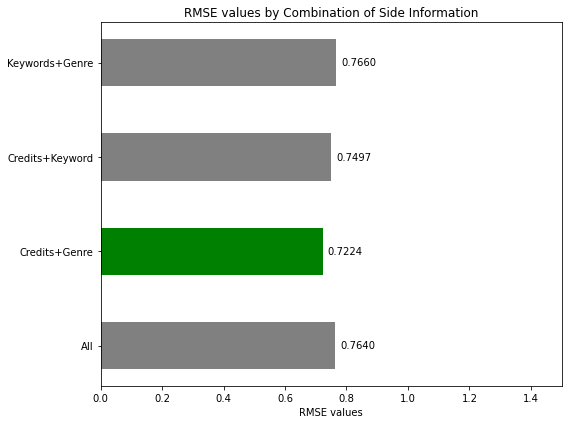

In [69]:
import matplotlib.pyplot as plt
import numpy as np

labels = ['All', 'Credits+Genre', 'Credits+Keyword', 'Keywords+Genre']
y = np.arange(len(labels))  # the label locations
height = 0.5  # the height of the bars

fig, ax = plt.subplots(figsize=(8, 6))  # Increase the figure size if needed

rmse_values = [rmse_ext, rmse_ext2, rmse_ext3, rmse_ext4]  # Example RMSE values for each model

# Set the colors for each bar, using yellow for rmse_ext3 and blue for others
colors = ['grey' if i != 1 else 'green' for i in range(len(rmse_values))]

rects = ax.barh(y, rmse_values, height, color=colors)  # Use barh() for horizontal bar chart

# Add some text for labels, title, and custom y-axis tick labels, etc.
ax.set_xlabel('RMSE values')  # Set the x-axis label
ax.set_title('RMSE values by Combination of Side Information')
ax.set_yticks(y)
ax.set_yticklabels(labels)  # Use y-axis labels for movies combination
ax.set_xlim([0, 1.5])  # Set the maximum value of the x-axis to 1.5

# Add RMSE values as annotations on the bars
for i, rmse_value in enumerate(rmse_values):
    ax.annotate(f'{rmse_value:.4f}', xy=(rmse_value, i), xytext=(5, 0), textcoords="offset points", va='center')

plt.tight_layout()  # Adjust the spacing to avoid overlapping

# Save the plot as a PNG file
plt.savefig('rmse_combine.png')

plt.show()
